# Research and Data Collection

In this notebook, we will gather data on vintage shops, charity shops, and related stores in London using the Google Places API. We will use this data to build a model that predicts the best shops for finding valuable deals.

Our data collection process will involve:

1. Querying the Google Places API to obtain a list of relevant shops in London.
2. Extracting the necessary information (e.g., shop name, location, rating) from the API response.
3. Organizing the data in a structured format for further processing and analysis.


## Pseudo code

- Import necessary libraries (e.g., requests, pandas)

- Define Google Places API key and base URL

- Create a function to query Google Places API: 
    1. Inputs: API key, location, radius, and search terms
    2. Outputs: A list of shops with relevant information (e.g., name, location, rating) 

- Call the function with appropriate parameters to search for vintage shops, charity shops, and related stores in London

- Organize the collected data into a structured format (e.g., DataFrame)

- Save the collected data to a file (e.g., CSV)


In [2]:
import os
from dotenv import load_dotenv

# Load the environment variables
load_dotenv()

# Access the Google API key
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')


In [4]:
import requests
import pandas as pd
import time
import numpy as np

# Define Google Places API key and base URL
api_key = GOOGLE_API_KEY
base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
reverse_geocode_url = "https://maps.googleapis.com/maps/api/geocode/json"

# Create a function to send a request to the Google Places API
def send_request(api_key, location, radius, keyword, pagetoken=None):
    params = {
        "key": api_key,
        "location": location,
        "radius": radius,
        "keyword": keyword,
        "pagetoken": pagetoken
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Request failed with status code {response.status_code}: {response.text}")

# Create a function to parse the response from the Google Places API
def parse_response(response):
    results = []
    for shop in response["results"]:
        lat = shop["geometry"]["location"]["lat"]
        lng = shop["geometry"]["location"]["lng"]
        results.append({
            "name": shop["name"],
            "address": shop["vicinity"],
            "latitude": lat,
            "longitude": lng,
            "rating": shop.get("rating", None)
        })
    next_page_token = response.get("next_page_token", None)
    return results, next_page_token

# Create a function to query Google Places API
def query_places(api_key, location, radius, search_terms):
    shops = []
    borough_cache = {}

    # Generate a grid of locations using numpy's meshgrid function
    latitudes = np.arange(float(location.split(',')[0]) - 0.025 * 2, float(location.split(',')[0]) + 0.025 * 3, 0.025)
    longitudes = np.arange(float(location.split(',')[1]) - 0.025 * 2, float(location.split(',')[1]) + 0.025 * 3, 0.025)
    locations = np.meshgrid(latitudes, longitudes)
    locations = np.vstack([locations[0].flatten(), locations[1].flatten()]).T

    for term in search_terms:
        for location in locations:
            location_str = f"{location[0]},{location[1]}"
            next_page_token = None

            while True:
                # Check if borough has been cached, and if not, retrieve it using the get_borough function
                if location_str not in borough_cache:
                    borough = get_borough(api_key, location[0], location[1])
                    borough_cache[location_str] = borough
                else:
                    borough = borough_cache[location_str]

                try:
                    response = send_request(api_key, location_str, radius, term, next_page_token)
                    results, next_page_token = parse_response(response)
                    for result in results:
                        result["borough"] = borough
                    shops.extend(results)
                except Exception as e:
                    print(f"Request failed: {e}")
                    time.sleep(5)
                    continue

                if not next_page_token:
                    break

                time.sleep(2)  # Wait for 2 seconds before requesting the next page to avoid exceeding the API limit

    return shops

# Updated get_borough function to cache results
borough_cache = {}

def get_borough(api_key, lat, lng):
    location_str = f"{lat},{lng}"
    if location_str in borough_cache:
        return borough_cache[location_str]

    params = {
        "key": api_key,
        "latlng": location_str
    }
    response = requests.get(reverse_geocode_url, params=params).json()
    if response["status"] == "OK":
        for result in response["results"]:
            for component in result["address_components"]:
                if "postal_town" in component["types"]:
                    borough = component["long_name"]
                    borough_cache[location_str] = borough
                    return borough
        # If borough information is not available, return None
        borough_cache[location_str] = None
        return None
    else:
        # If geocoding request fails, raise an exception
        raise Exception(f"Geocoding request failed with status code {response['status']}")




# Call the function with appropriate parameters
location = "51.5074,-0.1278"  # London coordinates
radius = 2500  # 2.5 km varying the radius will increase the number of shops returned but increases the API query run time
search_terms = ["vintage shop", "charity shop"]

shops_data = query_places(api_key, location, radius, search_terms)

# Organize the collected data into a DataFrame
shops_df = pd.DataFrame(shops_data)



In [5]:
from IPython.display import display

display(shops_df)


,name,address,latitude,longitude,rating,borough
0,Vintage80scasuals,"Unit 63, 105 Culvert Rd, London",51.470904,-0.156681,0.0,London
1,Accessories of Old,"Next to Safestore, Arch 10 Munster Rd, London",51.472579,-0.203859,0.0,London
2,Eclectica (Clapham),"803 Wandsworth Rd, London",51.466581,-0.148460,4.9,London
3,BajaboutiqueGB,"37 Elbe St, London",51.472878,-0.185076,0.0,London
4,INSIGHT Fulham Dress Agency,"201 Munster Rd, London",51.479447,-0.211883,5.0,London
...,...,...,...,...,...,...
2470,The Salvation Army (Clapton),"122 Lower Clapton Rd, London",51.554421,-0.053815,4.9,London
2471,Age UK,"36/44 High St, London",51.581862,-0.031678,4.0,London
2472,Charity Hub,"654 Kingsland Rd, London",51.546140,-0.075496,0.0,London
2473,The Salvation Army (Dalston),"Richmond Rd, London",51.543003,-0.074395,5.0,London


In [6]:
shops_df['borough'].unique() # had several attemps at fixing get_boroughs() with no success

array(['London'], dtype=object)

In [7]:
def extract_borough_from_address(address):
    boroughs = [
        "Barking and Dagenham", "Barnet", "Bexley", "Brent", "Bromley",
        "Camden", "Croydon", "Ealing", "Enfield", "Greenwich", "Hackney",
        "Hammersmith and Fulham", "Haringey", "Harrow", "Havering",
        "Hillingdon", "Hounslow", "Islington", "Kensington and Chelsea",
        "Kingston upon Thames", "Lambeth", "Lewisham", "Merton", "Newham",
        "Redbridge", "Richmond upon Thames", "Southwark", "Sutton",
        "Tower Hamlets", "Waltham Forest", "Wandsworth", "Westminster"
    ]

    for borough in boroughs:
        if borough in address:
            return borough

    return None


In [8]:
shops_df['borough_from_address'] = shops_df['address'].apply(extract_borough_from_address)


In [9]:
from IPython.display import display

display(shops_df)


,name,address,latitude,longitude,rating,borough,borough_from_address
0,Vintage80scasuals,"Unit 63, 105 Culvert Rd, London",51.470904,-0.156681,0.0,London,None
1,Accessories of Old,"Next to Safestore, Arch 10 Munster Rd, London",51.472579,-0.203859,0.0,London,None
2,Eclectica (Clapham),"803 Wandsworth Rd, London",51.466581,-0.148460,4.9,London,Wandsworth
3,BajaboutiqueGB,"37 Elbe St, London",51.472878,-0.185076,0.0,London,None
4,INSIGHT Fulham Dress Agency,"201 Munster Rd, London",51.479447,-0.211883,5.0,London,None
...,...,...,...,...,...,...,...
2470,The Salvation Army (Clapton),"122 Lower Clapton Rd, London",51.554421,-0.053815,4.9,London,None
2471,Age UK,"36/44 High St, London",51.581862,-0.031678,4.0,London,None
2472,Charity Hub,"654 Kingsland Rd, London",51.546140,-0.075496,0.0,London,None
2473,The Salvation Army (Dalston),"Richmond Rd, London",51.543003,-0.074395,5.0,London,None


In [10]:
shops_df['borough_from_address'].unique() # still not working properly

array([None, 'Wandsworth', 'Camden', 'Hackney', 'Bromley', 'Lewisham',
       'Harrow', 'Islington', 'Southwark'], dtype=object)

In [11]:
# UK Postcodes API (https://postcodes.io/) 
import requests

def get_borough(lat, lng):
    uk_postcodes_api_url = f"https://api.postcodes.io/postcodes?lon={lng}&lat={lat}"
    response = requests.get(uk_postcodes_api_url).json()

    if response["status"] == 200 and response["result"]:
        for result in response["result"]:
            if "admin_district" in result:
                return result["admin_district"]
    return None


In [12]:
shops_df['borough_from_lat_lng'] = shops_df.apply(lambda row: get_borough(row['latitude'], row['longitude']), axis=1)

In [13]:
display(shops_df)

,name,address,latitude,longitude,rating,borough,borough_from_address,borough_from_lat_lng
0,Vintage80scasuals,"Unit 63, 105 Culvert Rd, London",51.470904,-0.156681,0.0,London,None,Wandsworth
1,Accessories of Old,"Next to Safestore, Arch 10 Munster Rd, London",51.472579,-0.203859,0.0,London,None,Hammersmith and Fulham
2,Eclectica (Clapham),"803 Wandsworth Rd, London",51.466581,-0.148460,4.9,London,Wandsworth,Lambeth
3,BajaboutiqueGB,"37 Elbe St, London",51.472878,-0.185076,0.0,London,None,Hammersmith and Fulham
4,INSIGHT Fulham Dress Agency,"201 Munster Rd, London",51.479447,-0.211883,5.0,London,None,Hammersmith and Fulham
...,...,...,...,...,...,...,...,...
2470,The Salvation Army (Clapton),"122 Lower Clapton Rd, London",51.554421,-0.053815,4.9,London,None,Hackney
2471,Age UK,"36/44 High St, London",51.581862,-0.031678,4.0,London,None,Waltham Forest
2472,Charity Hub,"654 Kingsland Rd, London",51.546140,-0.075496,0.0,London,None,Hackney
2473,The Salvation Army (Dalston),"Richmond Rd, London",51.543003,-0.074395,5.0,London,None,Hackney


In [14]:
shops_df['borough_from_address'].unique() # fixed

array([None, 'Wandsworth', 'Camden', 'Hackney', 'Bromley', 'Lewisham',
       'Harrow', 'Islington', 'Southwark'], dtype=object)

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [17]:
# Checking unique boroughs from lat_lng
unique_boroughs = shops_df['borough_from_lat_lng'].unique()
print("Unique boroughs from lat_lng:", unique_boroughs)

# Counting the number of shops per borough
borough_counts = shops_df['borough_from_lat_lng'].value_counts()
print("Number of shops per borough:\n", borough_counts)

# the number of shops for large (land) boroughs like Greenwich is incorrect
# however, the Google Places API doesn't appear to return more results even if the radius of search is reduced below 2.5km

Unique boroughs from lat_lng: ['Wandsworth' 'Hammersmith and Fulham' 'Lambeth' 'Kensington and Chelsea'
 None 'Westminster' 'Camden' 'Brent' 'Haringey' 'Islington' 'Southwark'
 'Tower Hamlets' 'Hackney' 'Lewisham' 'City of London' 'Waltham Forest'
 'Barnet' 'Greenwich']
Number of shops per borough:
 borough_from_lat_lng
Camden                    421
Westminster               334
Tower Hamlets             275
Southwark                 251
Hackney                   244
Islington                 238
Lambeth                   182
Wandsworth                175
Kensington and Chelsea    166
Haringey                   62
Hammersmith and Fulham     57
Lewisham                   35
Brent                      20
Barnet                      8
Waltham Forest              3
Greenwich                   2
City of London              1
Name: count, dtype: int64


In [18]:
# Save the collected data to a CSV file
shops_df.to_csv("vintage_shops_london.csv", index=False)


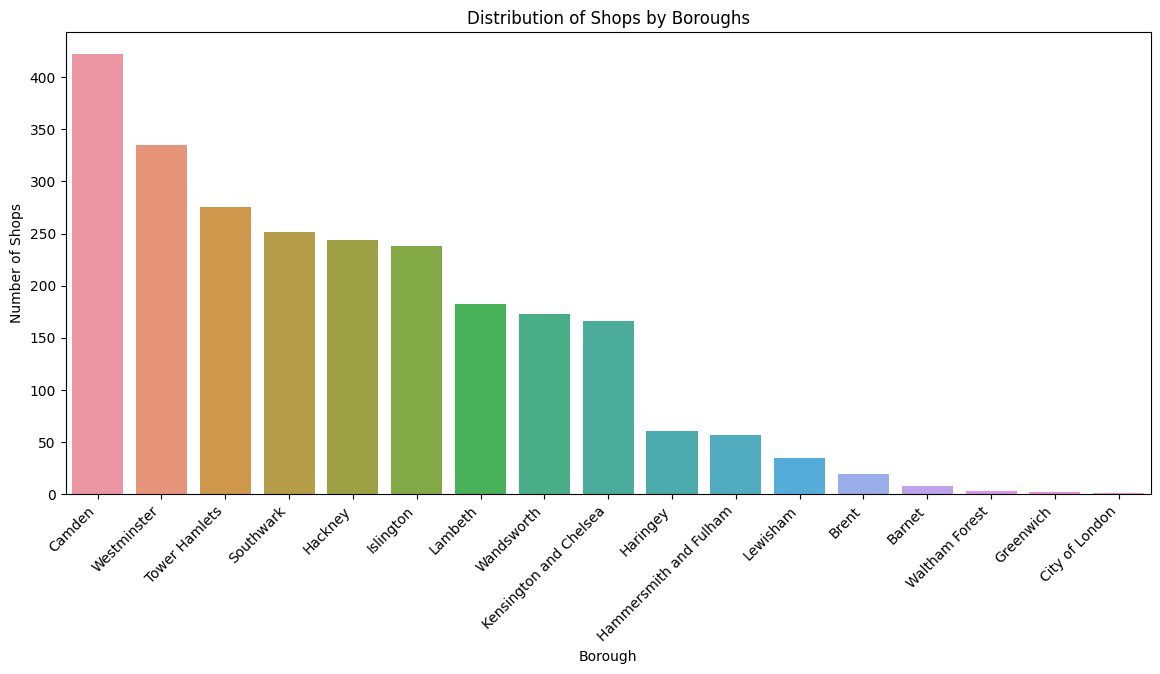

In [80]:
# Visualizing the distribution of shops by boroughs
plt.figure(figsize=(14, 6))
sns.countplot(data=shops_df, x='borough_from_lat_lng', order=shops_df['borough_from_lat_lng'].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Borough')
plt.ylabel('Number of Shops')
plt.title('Distribution of Shops by Boroughs')
plt.show()


## Average Income

The London Datastore provides data on earnings by place of residence, which you can use to estimate average income in different areas of London. You can find this dataset here: [https://data.london.gov.uk/dataset/earnings-place-residence-borough](https://data.london.gov.uk/dataset/earnings-place-residence-borough)

## Housing Prices

The London Datastore also provides data on average house prices in London. This dataset is available at the following link: [https://data.london.gov.uk/dataset/average-house-prices](https://data.london.gov.uk/dataset/average-house-prices)

## Indices of Deprivation

Another useful dataset for understanding the affluence of an area is the Indices of Deprivation. This dataset provides a relative measure of deprivation across small areas in England, including income, employment, health, education, and more. You can find this dataset here: [https://data.london.gov.uk/dataset/indices-of-deprivation](https://data.london.gov.uk/dataset/indices-of-deprivation)


In [104]:
import pandas as pd

url = "https://data.london.gov.uk/download/earnings-place-residence-borough/1686ef1c-b169-442d-8877-e7e49788f668/earnings-residence-borough.xlsx"
earnings_df = pd.read_excel(url, sheet_name='Total, weekly')

print(earnings_df.head())





   Code                  Area     2002 Unnamed: 3     2003 Unnamed: 5   
0   NaN                   NaN  Pay (£)     conf %  Pay (£)     conf %  \
1   NaN                   NaN      NaN        NaN      NaN        NaN   
2  00AA        City of London        !          !        !          !   
3  00AB  Barking and Dagenham    383.3        5.5    354.9        6.5   
4  00AC                Barnet    427.4        5.1    450.1          5   

      2004 Unnamed: 7     2005 Unnamed: 9  ...     2017 Unnamed: 33     2018   
0  Pay (£)     conf %  Pay (£)     conf %  ...  Pay (£)      conf %  Pay (£)  \
1      NaN        NaN      NaN        NaN  ...      NaN         NaN      NaN   
2        #          #        #          #  ...        #           #    909.4   
3    360.1        5.2    375.1        5.1  ...      461         5.1    479.1   
4    453.3        5.6    442.3        5.3  ...    522.6         4.5    536.6   

  Unnamed: 35     2019 Unnamed: 37     2020 Unnamed: 39     2021 Unnamed: 41  
0

In [34]:
import pandas as pd

url = "https://data.london.gov.uk/download/earnings-place-residence-borough/1686ef1c-b169-442d-8877-e7e49788f668/earnings-residence-borough.xlsx"
earnings_df = pd.read_excel(url, sheet_name='Total, weekly', header=[0, 1], skiprows=[2])

# Select the 'Code', 'Area', and 2021 'Pay (£)' columns
selected_columns = earnings_df[[( 'Code', 'Unnamed: 0_level_1'),
                                ('Area', 'Unnamed: 1_level_1'),
                                (  2021,            'Pay (£)')]]

# Reset column names
selected_columns.columns = ['Code', 'Area', 'Pay_2021']

print(selected_columns.head())



   Code                  Area Pay_2021
0  00AA        City of London        #
1  00AB  Barking and Dagenham    523.5
2  00AC                Barnet    574.9
3  00AD                Bexley    584.8
4  00AE                 Brent    553.1


In [46]:
selected_columns.to_csv('earnings_residence_borough_2021.csv', index=False)

In [38]:
import pandas as pd

url = "https://data.london.gov.uk/download/average-house-prices/b1b0079e-698c-4c0b-b8c7-aa6189590ca4/land-registry-house-prices-borough.csv"
house_prices_df = pd.read_csv(url)

print(house_prices_df.head())



        Code                  Area                  Year Measure    Value
0  E09000001        City of London  Year ending Dec 1995  Median  105,000
1  E09000002  Barking and Dagenham  Year ending Dec 1995  Median   49,000
2  E09000003                Barnet  Year ending Dec 1995  Median   85,125
3  E09000004                Bexley  Year ending Dec 1995  Median   62,000
4  E09000005                 Brent  Year ending Dec 1995  Median   68,000


In [39]:
display(house_prices_df)


,Code,Area,Year,Measure,Value
0,E09000001,City of London,Year ending Dec 1995,Median,"105,000"
1,E09000002,Barking and Dagenham,Year ending Dec 1995,Median,"49,000"
2,E09000003,Barnet,Year ending Dec 1995,Median,"85,125"
3,E09000004,Bexley,Year ending Dec 1995,Median,"62,000"
4,E09000005,Brent,Year ending Dec 1995,Median,"68,000"
...,...,...,...,...,...
12010,E12000008,South East,Year ending Dec 2017,Sales,"148,025"
12011,E12000009,South West,Year ending Dec 2017,Sales,"102,292"
12012,E92000001,England,Year ending Dec 2017,Sales,"837,501"
12013,W92000076,Wales,Year ending Dec 2017,Sales,"46,828"


> Notes
-  Excluded from the above figures are sales at less than market price (e.g. Right To Buy), sales below £1,000 and sales above £20m.
-  The "median" property price is determined by ranking all property prices in ascending order.
-  The median is the mid-point of this ranking with 50 per cent of prices below the median and 50 per cent above.
-  Simple average values are useful in describing data, but there are limitations. These limitations occur when there are extreme values (either low or high) in the data. These extreme values have a larger influence on the average than the other values in the data set. One way to reduce the influence of extremes is by calculating a geometric mean instead of an arithmetic mean (the arithmetic mean is commonly referred to as the average). To calculate a geometric mean, the data are transformed into log values and these values are averaged. The average is then converted back to a linear value, which is the geometric mean. This technique reduces the influence of individual values because in log form, low/high values are not as extreme relative to the rest


In [40]:
import re
house_prices_df = house_prices_df.loc[house_prices_df['Measure'] == 'Median']
house_prices_df['Year'] = house_prices_df['Year'].apply(lambda x: re.sub('[^0-9]', '', x)).astype(int)
house_prices_df = house_prices_df.loc[house_prices_df.groupby('Area')['Year'].idxmax()]
house_prices_final = house_prices_df.loc[:, ['Code', 'Area', 'Value']]


In [43]:
house_prices_df.head()
house_prices_df['Year'].max()

2017

In [29]:
display(house_prices_final)

,Code,Area,Value
3826,E09000002,Barking and Dagenham,"300,000"
3827,E09000003,Barnet,"482,951"
3828,E09000004,Bexley,"330,000"
3829,E09000005,Brent,"450,000"
3830,E09000006,Bromley,"425,000"
3831,E09000007,Camden,"717,500"
3825,E09000001,City of London,"831,400"
3832,E09000008,Croydon,"345,000"
3833,E09000009,Ealing,"465,050"
3861,E12000004,East Midlands,"172,000"


In [44]:
house_prices_final.to_csv('london_house_prices_2017.csv')

In [6]:
import pandas as pd
import requests
from io import BytesIO

url = "https://data.london.gov.uk/download/indices-of-deprivation/9ee0cf66-e6f9-4e38-8eec-79c1d897e248/ID%202019%20for%20London.xls"
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Read the Excel file from the response content
    excel_file = BytesIO(response.content)
    xls = pd.read_excel(excel_file, sheet_name=None)

    # List the sheet names
    print("Sheet names:")
    for sheet_name in xls.keys():
        print(sheet_name)
else:
    print("Failed to download the Excel file.")


Sheet names:
Notes
IMD 2019
Sub domains
IDACI and IDAOPI
Borough summary measures
Borough domain summaries
Borough IDACI IDAOPI
Population figures
Underlying indicators
Underlying indicators notes


In [4]:
import pandas as pd
import requests
from io import BytesIO

url = "https://data.london.gov.uk/download/indices-of-deprivation/9ee0cf66-e6f9-4e38-8eec-79c1d897e248/ID%202019%20for%20London.xls"
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Read the Excel file from the response content
    excel_file = BytesIO(response.content)

    # Read the "IMD 2019" sheet and display its content
    imd_2019_df = pd.read_excel(excel_file, sheet_name="IMD 2019")
    print("IMD 2019 sheet:")
    print(imd_2019_df.head())

    # Read the "Notes" sheet and display its content
    excel_file.seek(0)  # Reset the file pointer to read the file again
    notes_df = pd.read_excel(excel_file, sheet_name=1)
    print("\nNotes sheet:")
    print(notes_df)
else:
    print("Failed to download the Excel file.")


IMD 2019 sheet:
  LSOA code (2011)     LSOA name (2011) Local Authority District code (2019)   
0        E01000001  City of London 001A                            E09000001  \
1        E01000002  City of London 001B                            E09000001   
2        E01000003  City of London 001C                            E09000001   
3        E01000005  City of London 001E                            E09000001   
4        E01032739  City of London 001F                            E09000001   

  Local Authority District name (2019)   
0                       City of London  \
1                       City of London   
2                       City of London   
3                       City of London   
4                       City of London   

   Index of Multiple Deprivation (IMD) Score   
0                                      6.208  \
1                                      5.143   
2                                     19.402   
3                                     28.652   
4         

In [7]:
import pandas as pd
import requests

url = "https://data.london.gov.uk/download/indices-of-deprivation/9ee0cf66-e6f9-4e38-8eec-79c1d897e248/ID%202019%20for%20London.xls"
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Read the Excel file from the response content
    excel_file = pd.ExcelFile(response.content)

    # Read the "IMD 2019" sheet into a DataFrame
    imd_2019_df = pd.read_excel(excel_file, sheet_name="IMD 2019")

    # Save the DataFrame as a CSV file
    #imd_2019_df.to_csv("IMD 2019 for London.csv", index=False)
else:
    print("Failed to download the Excel file.")


In [8]:
display(imd_2019_df)

,LSOA code (2011),LSOA name (2011),Local Authority District code (2019),Local Authority District name (2019),Index of Multiple Deprivation (IMD) Score,Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived),Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs),Income Score (rate),Income Rank (where 1 is most deprived),Income Decile (where 1 is most deprived 10% of LSOAs),...,Health Deprivation and Disability Decile (where 1 is most deprived 10% of LSOAs),Crime Score,Crime Rank (where 1 is most deprived),Crime Decile (where 1 is most deprived 10% of LSOAs),Barriers to Housing and Services Score,Barriers to Housing and Services Rank (where 1 is most deprived),Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs),Living Environment Score,Living Environment Rank (where 1 is most deprived),Living Environment Decile (where 1 is most deprived 10% of LSOAs)
0,E01000001,City of London 001A,E09000001,City of London,6.208,29199,9,0.007,32831,10,...,10,-2.012,32662,10,29.472,7319,3,31.873,7789,3
1,E01000002,City of London 001B,E09000001,City of London,5.143,30379,10,0.034,29901,10,...,10,-2.343,32789,10,24.412,11707,4,23.084,13070,4
2,E01000003,City of London 001C,E09000001,City of London,19.402,14915,5,0.086,18510,6,...,6,-1.032,29363,9,40.103,2157,1,40.535,4092,2
3,E01000005,City of London 001E,E09000001,City of London,28.652,8678,3,0.211,6029,2,...,6,-1.317,31059,10,39.900,2217,1,28.979,9397,3
4,E01032739,City of London 001F,E09000001,City of London,13.584,20391,7,0.014,32638,10,...,8,-1.560,31947,10,46.314,837,1,49.165,2040,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4830,E01033604,Westminster 009J,E09000033,Westminster,33.467,6478,2,0.204,6406,2,...,6,1.363,1493,1,27.769,8637,3,45.528,2782,1
4831,E01033605,Westminster 009K,E09000033,Westminster,40.540,4098,2,0.313,1872,1,...,4,0.705,6453,2,25.353,10791,4,34.149,6610,3
4832,E01033606,Westminster 014F,E09000033,Westminster,14.013,19938,7,0.077,20193,7,...,7,0.136,14545,5,25.424,10720,4,34.478,6478,2
4833,E01033607,Westminster 014G,E09000033,Westminster,22.192,12626,4,0.125,13074,4,...,8,1.095,2834,1,23.500,12671,4,43.709,3235,1


In [11]:
import pandas as pd
import requests

url = "https://data.london.gov.uk/download/indices-of-deprivation/9ee0cf66-e6f9-4e38-8eec-79c1d897e248/ID%202019%20for%20London.xls"
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Read the Excel file from the response content
    xls_file = pd.ExcelFile(response.content)

    # Read the "Notes" sheet into a DataFrame
    notes_df = pd.read_excel(xls_file, sheet_name="Notes")

    # Print the first few rows of the DataFrame
    print(notes_df.head())

else:
    print("Failed to download the Excel file.")


Empty DataFrame
Columns: []
Index: []


> Dictinoary for imd_2019_df is [Indicies of deprivation](https://data.london.gov.uk/download/indices-of-deprivation/5f72f768-7092-45b5-accf-dc004fa670a9/Indices%20of%20Deprivation%202019%20ward%20level%20summary%20measures%20for%20London.pdf)

After reviewing the document dictionary, it seems that the most relevant columns for the project would be:

- Local Authority District code (2019) - This column represents the code for each local authority district, which can be useful for matching data from other sources.
- Local Authority District name (2019) - This column contains the names of the local authority districts, which can provide more context and better understanding of the data.
- Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived) - This column ranks the areas based on their deprivation level. A lower rank indicates a higher level of deprivation.
- Income Rank (where 1 is most deprived) - This column ranks the areas based on income levels. A lower rank indicates a higher level of income deprivation.

In [13]:
# Keep only the relevant columns
imd_2019_df_filtered = imd_2019_df[['Local Authority District code (2019)', 'Local Authority District name (2019)', 'Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)', 'Income Rank (where 1 is most deprived)']]

# Display the filtered DataFrame
print(imd_2019_df_filtered.head())


  Local Authority District code (2019) Local Authority District name (2019)   
0                            E09000001                       City of London  \
1                            E09000001                       City of London   
2                            E09000001                       City of London   
3                            E09000001                       City of London   
4                            E09000001                       City of London   

   Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)   
0                                              29199                    \
1                                              30379                     
2                                              14915                     
3                                               8678                     
4                                              20391                     

   Income Rank (where 1 is most deprived)  
0                                   

In [16]:
display(imd_2019_df_filtered)

,Local Authority District code (2019),Local Authority District name (2019),Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived),Income Rank (where 1 is most deprived)
0,E09000001,City of London,29199,32831
1,E09000001,City of London,30379,29901
2,E09000001,City of London,14915,18510
3,E09000001,City of London,8678,6029
4,E09000001,City of London,20391,32638
...,...,...,...,...
4830,E09000033,Westminster,6478,6406
4831,E09000033,Westminster,4098,1872
4832,E09000033,Westminster,19938,20193
4833,E09000033,Westminster,12626,13074


In [45]:
# Save the collected data to a CSV file
imd_2019_df_filtered.to_csv('imd_2019_london_filtered.csv', index=False) # Indices of Multiple Deprivation (IMD)

In [54]:
folder_path = os.getcwd()
print(folder_path)

/Users/andrii/Documents/londons_fashionable_finds/01_Data_Collection


In [52]:
import os
import glob

# Set the path to the folder
folder_path = os.getcwd()

# Find all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Print the list of CSV file names
for file in csv_files:
    file_name = os.path.basename(file)
    print(file_name)


london_house_prices_2017.csv
earnings_residence_borough_2021.csv
imd_2019_london_filtered.csv
vintage_shops_london.csv


In [7]:
os.getcwd()

'/Users/andrii/Documents/londons_fashionable_finds/01_Data_Collection'